In [1]:
# Preliminaries
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

# disable warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()


# 1. Data Processing
1. load data, drop nan rows
2. df containing historical prices
3. Confirm correlation

In [3]:
# func for loading data, pase time as index, drop nan rows
def loadData(ticker, root):
    """
    Automate data loading process: loading, parse time as index, drop nan rows
    Input: ticker(str), root(default to data storage folder)
    output: df for each ticker
    """
    # load
    df = pd.read_csv(root + f'{ticker}.csv', index_col='Date', parse_dates=True)
    # drop nan rows
    df.dropna(axis=0, inplace=True)
    df
    return df



In [4]:
# load data
rut = loadData('djia', 'C:/Users/Allen/Desktop/FRE 7773/Assignments/A3/A3 Data/').rename(columns={"PX_LAST":"rut"}).drop(columns=['PX_VOLUME'])
spx = loadData('spy', 'C:/Users/Allen/Desktop/FRE 7773/Assignments/A3/A3 Data/').rename(columns={"PX_LAST":"spx"}).drop(columns=['PX_VOLUME'])
rut
spx

,rut
Date,
2000-01-03,113.5000
2000-01-04,109.7656
2000-01-05,111.1875
2000-01-06,111.7500
2000-01-07,115.5000
...,...
2021-12-27,362.9200
2021-12-28,363.9900
2021-12-29,364.8400


,spx
Date,
2000-01-03,145.4375
2000-01-04,139.7500
2000-01-05,140.0000
2000-01-06,137.7500
2000-01-07,145.7500
...,...
2021-12-27,477.2600
2021-12-28,476.8700
2021-12-29,477.4800


In [5]:
df = spx.merge(rut, how='outer', left_index=True, right_index=True)
df.dropna(axis=0, inplace=True)
df

,spx,rut
Date,,
2000-01-03,145.4375,113.5000
2000-01-04,139.7500,109.7656
2000-01-05,140.0000,111.1875
2000-01-06,137.7500,111.7500
2000-01-07,145.7500,115.5000
...,...,...
2021-12-27,477.2600,362.9200
2021-12-28,476.8700,363.9900
2021-12-29,477.4800,364.8400


<AxesSubplot: xlabel='Date'>

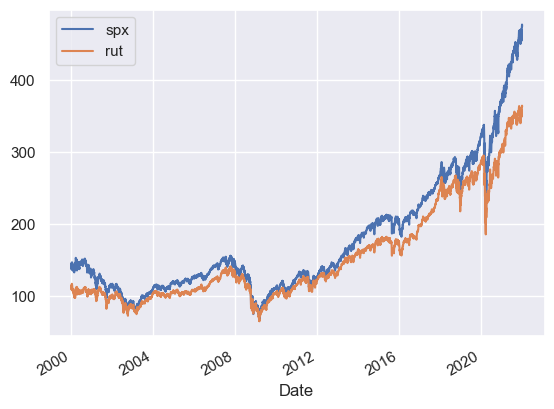

In [6]:
df.plot()

In [7]:
# confirm correlation
print(df['spx'].corr(df['rut'])) 

0.9920149453250622


# 2. Rolling Linear Regression Residual and Sigma^2 
1. formula for rolling ols: spy = beta * rut + v
2. rolling period: 6mo * 20 trading days/mo = 120days/window
3. rollingOLS reference: https://lost-stats.github.io/Time_Series/Rolling_Regression.html

In [8]:
# rolling reg model
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

roll_period = 120
# supress y-intercept using -1
roll_reg = RollingOLS.from_formula('spx ~ rut -1', window=roll_period, data=df)
roll_model = roll_reg.fit()


<AxesSubplot: xlabel='Date'>

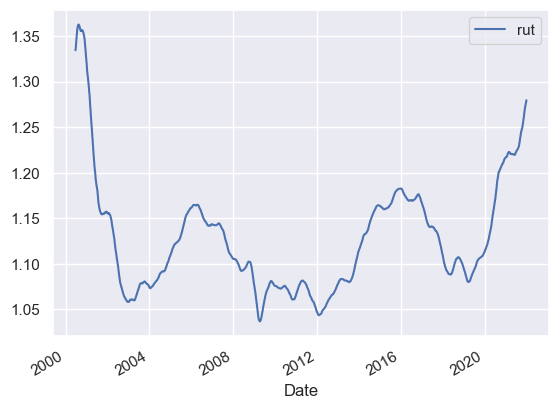

In [9]:
# plot beta vs. time
roll_model.params.plot()


In [10]:
# compute residuals, put into df, remove nan rows
roll_res = pd.DataFrame(df['spx'] - roll_model.params['rut'] * df['rut'], columns=['res'])

# roll_model.params
roll_res.dropna(axis=0, inplace=True)
roll_res


,res
Date,
2000-06-22,6.828869
2000-06-23,4.903965
2000-06-26,4.622642
2000-06-27,4.230472
2000-06-28,4.499636
...,...
2021-12-27,13.574960
2021-12-28,11.636351
2021-12-29,10.973122


<AxesSubplot: xlabel='Date'>

,res
count,5417.000000
mean,0.291122
std,3.607507
min,-12.312031
25%,-1.413817
50%,0.166445
75%,1.801312
max,19.516543


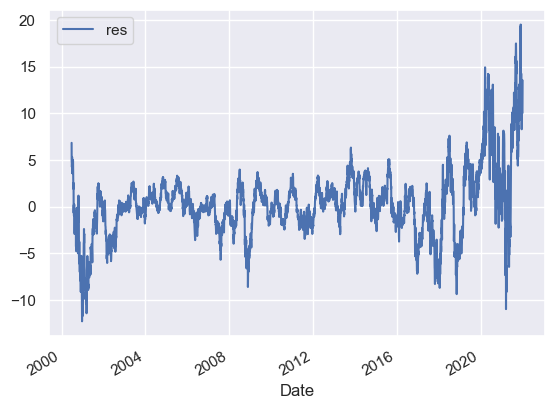

In [11]:
# plot residual
roll_res.plot()
roll_res.describe()

In [12]:
# find residual var_t
def stdt(res):
    """
    take res df, add var_t col
    input: df res
    output: df res with additional col named var
    """
    res['std'] = np.nan
    for i in range(len(res)):
        res.iloc[i-1,1] = np.std(res.iloc[:i, 0], ddof=1)
    res.iloc[-1, 1] = np.std(res.iloc[:,0], ddof=1)
    return res


In [13]:
stdt(roll_res)


,res,std
Date,,
2000-06-22,6.828869,NaN
2000-06-23,4.903965,1.361113
2000-06-26,4.622642,1.200822
2000-06-27,4.230472,1.155093
2000-06-28,4.499636,1.041328
...,...,...
2021-12-27,13.574960,3.597526
2021-12-28,11.636351,3.600501
2021-12-29,10.973122,3.603097


In [14]:
roll_res.describe()

,res,std
count,5417.000000,5416.000000
mean,0.291122,2.840598
std,3.607507,0.477174
min,-12.312031,0.772302
25%,-1.413817,2.480067
50%,0.166445,2.677645
75%,1.801312,3.122310
max,19.516543,4.606058


In [15]:
# sse for comparison with kf
roll_res['res2'] = roll_res['res'] ** 2
roll_sse = roll_res['res2'].sum()
roll_sse

70943.52248774839

# 3. Kalman Filter Set up
to simplify reference to parts of the equation, we denote the beta-hat_t|t formula as follows:

b_t = b_t-1 + k_gain * r_t

where b_t is the current beta, b_t-1 is the previous beta, r_t is current residual using current prices and b_t-1, k_gain is current feature / (current feature^2 * gamma^-1), where gamma = state variance / measurement error

 

In [16]:
# run first 120 day model (matching window), to establish baseline for kf model (b_0)
# compute base case
import statsmodels.api as sm
from statsmodels.formula.api import ols

# get first 120 lines
base_df = df.iloc[:roll_period]
base_reg = ols('spx ~ rut -1', data=base_df)
base_model = base_reg.fit()
base_model.params

rut    1.334578
dtype: float64

In [17]:
# keep original df intact
kf = df.copy(deep=True)

In [18]:
# create new columns to contain needed variables
kf['Qt'] = np.nan
kf['Rt'] = np.nan
kf['wt'] = np.nan
kf['vt'] = np.nan
kf['b_tt-1'] = np.nan
kf['r_t'] = np.nan
kf['sv'] = np.nan
kf['me'] = np.nan
kf['gamma'] = np.nan
kf['b_tt'] = np.nan
kf

,spx,rut,Qt,Rt,wt,vt,b_tt-1,r_t,sv,me,gamma,b_tt
Date,,,,,,,,,,,,
2000-01-03,145.4375,113.5000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,139.7500,109.7656,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,140.0000,111.1875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,137.7500,111.7500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,145.7500,115.5000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,477.2600,362.9200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-28,476.8700,363.9900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-29,477.4800,364.8400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Qt = sigw: var of  b_t, updated by row; initialized by random.rand

Rt = sigv: var of tgt, updated by row; initialized by rand generation according to 120 day ols var

wt (dist with var = Qt = sigw^2): generated from Qt

vt (dist with var = Rt = sigv^2): generated from Rt

b_tt-1: b_t-1 + wt; b_t-1 initialized by roll_period rows ols (b_0)

r_t = tgt - fea * b_tt-1

sv = P_tt-1: var of all b_tt-1 of prev rows; initialized with a rand sample from N(0, Qt)

me = Rt = sigv: var of spy of prev rows, updated by row

gamma = sv / me

b_tt = b_tt-1 + fea * r_t / (fea^2 + gamma^-1)

In [19]:
# fill in from 121st row
# Qt random initialize
kf.iloc[roll_period, 2] = np.random.rand()
# Rt initialize from var of spy for 1st 120r
kf.iloc[roll_period, 3] = np.var(kf.iloc[:roll_period, 1], ddof=1)
# generate wt
kf.iloc[roll_period, 4] = np.random.normal(0, kf.iloc[roll_period, 2])
# generate vt
kf.iloc[roll_period, 5] = np.random.normal(0, kf.iloc[roll_period, 3])
# compute b_tt-1
kf.iloc[roll_period, 6] = base_model.params[0] + kf.iloc[roll_period, 4]
# compute r_t
kf.iloc[roll_period, 7] = kf.iloc[roll_period, 0] - kf.iloc[roll_period, 1] * kf.iloc[roll_period, 6]
# initialize sv
kf.iloc[roll_period, 8] = np.random.normal(0, kf.iloc[roll_period, 2])
# insert me = Rt
kf.iloc[roll_period, 9] = kf.iloc[roll_period, 3]
# compute gamma
kf.iloc[roll_period, 10] = kf.iloc[roll_period, 8] / kf.iloc[roll_period, 9]
# compute b_tt
kf.iloc[roll_period, 11] = (kf.iloc[roll_period, 6] + kf.iloc[roll_period, 1] * kf.iloc[roll_period, 7] /
                            (kf.iloc[roll_period, 1] ** 2 + kf.iloc[roll_period, 10] ** (-1)))


In [20]:
kf.iloc[120:124]

,spx,rut,Qt,Rt,wt,vt,b_tt-1,r_t,sv,me,gamma,b_tt
Date,,,,,,,,,,,,
2000-06-23,144.3750,104.4375,0.640941,17.369466,0.287476,-22.175122,1.622055,-25.028323,-0.571918,17.369466,-0.032927,1.381737
2000-06-26,146.2344,105.9688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-06-27,145.1563,105.3750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-06-28,145.5625,105.3750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# fill b_0 into kf[119, b_tt]
kf.iloc[roll_period - 1, 11] = base_model.params[0]
kf.iloc[roll_period - 1, 6] = base_model.params[0]
kf.iloc[roll_period - 1]

spx       145.625000
rut       104.000000
Qt               NaN
Rt               NaN
wt               NaN
vt               NaN
b_tt-1      1.334578
r_t              NaN
sv               NaN
me               NaN
gamma            NaN
b_tt        1.334578
Name: 2000-06-22 00:00:00, dtype: float64

In [22]:
# fill in val of all following rows:
for i in range(roll_period + 1, len(kf)):
    # compute Qt 
    kf.iloc[i, 2] = np.var(kf.iloc[roll_period - 1:i, 11], ddof=1)
    # compute Rt
    kf.iloc[i, 3] = np.var(kf.iloc[roll_period - 1:i, 0], ddof=1)
    # generate wt
    kf.iloc[i, 4] = np.random.normal(0, kf.iloc[i, 2])
    # generate vt
    kf.iloc[i, 5] = np.random.normal(0, kf.iloc[i, 3])
    # compute b_tt-1
    kf.iloc[i, 6] = kf.iloc[i - 1, 11] + kf.iloc[i, 4]
    # compute r_t
    kf.iloc[i, 7] = kf.iloc[i, 0] - kf.iloc[i, 1] * kf.iloc[i, 6]
    # compute sv
    kf.iloc[i, 8] = np.var(kf.iloc[119:i, 6], ddof=1)
    # insert me = Rt
    kf.iloc[i, 9] = kf.iloc[i, 3]
    # compute gamma
    kf.iloc[i, 10] = kf.iloc[i, 8] / kf.iloc[i, 9]
    # compute b_tt
    kf.iloc[i, 11] = kf.iloc[i, 6] + kf.iloc[i, 1] * kf.iloc[i, 7] / (kf.iloc[i, 1] ** 2 + kf.iloc[i, 10] ** (-1))


In [23]:
kf[roll_period:roll_period + 15]

,spx,rut,Qt,Rt,wt,vt,b_tt-1,r_t,sv,me,gamma,b_tt
Date,,,,,,,,,,,,
2000-06-23,144.3750,104.4375,0.640941,17.369466,0.287476,-22.175122,1.622055,-25.028323,-0.571918,17.369466,-0.032927,1.381737
2000-06-26,146.2344,105.9688,0.001112,0.781250,0.001627,0.826295,1.383364,-0.358995,0.041321,0.781250,0.052891,1.379982
2000-06-27,145.1563,105.3750,0.000715,0.898539,-0.000394,0.728308,1.379588,-0.217760,0.023666,0.898539,0.026338,1.377528
2000-06-28,145.5625,105.3750,0.000513,0.615304,-0.000209,-0.482366,1.377319,0.427505,0.016902,0.615304,0.027470,1.381363
2000-06-29,144.1875,104.2500,0.000418,0.470708,-0.000282,0.591798,1.381080,0.209870,0.013230,0.470708,0.028106,1.383087
2000-06-30,145.2813,104.3750,0.000359,0.617824,-0.000797,0.550412,1.382290,1.004734,0.010828,0.617824,0.017526,1.391866
2000-07-03,147.2813,105.9688,0.000350,0.516041,-0.000051,-0.216423,1.391816,-0.207762,0.009158,0.516041,0.017747,1.389865
2000-07-05,144.6250,105.0000,0.000325,0.982163,0.000324,0.195417,1.390189,-1.344819,0.007885,0.982163,0.008028,1.377524
2000-07-06,145.7500,105.0938,0.000284,0.937403,0.000036,0.112331,1.377560,0.976967,0.006929,0.937403,0.007392,1.386744


In [24]:
kf.tail()

,spx,rut,Qt,Rt,wt,vt,b_tt-1,r_t,sv,me,gamma,b_tt
Date,,,,,,,,,,,,
2021-12-27,477.26,362.92,0.003865,7365.410277,-0.004283,-18118.026781,1.282826,11.696729,0.003940,7365.410277,5.349749e-07,1.284948
2021-12-28,476.87,363.99,0.003869,7380.616911,0.002727,-3868.489553,1.287675,8.169288,0.003944,7380.616911,5.343928e-07,1.289159
2021-12-29,477.48,364.84,0.003873,7395.768698,-0.010992,-16076.497328,1.278166,11.153777,0.003948,7395.768698,5.338552e-07,1.280195
2021-12-30,476.16,364.07,0.003877,7410.976215,-0.004314,-6503.356043,1.275880,11.650206,0.003952,7410.976215,5.332409e-07,1.277993
2021-12-31,474.96,363.32,0.003880,7426.026318,0.006332,-14295.955907,1.284325,8.339208,0.003955,7426.026318,5.326228e-07,1.285832


In [ ]:
# plot b_tt
plt.plot(kf['b_tt'], c='grey')
plt.plot(roll_model.params, c='b')

kf: grey, roll: blue <br>

In [ ]:
# compute residuals
kf_res = pd.DataFrame(kf['spx'] - kf['rut'] * kf['b_tt'], columns=['res'])

# plot residuals
plt.plot(kf_res, c='grey')
plt.plot(roll_res.iloc[:,0], c='b')

In [ ]:
kf_res.describe()

In [ ]:
stdt(kf_res)

In [ ]:
kf_res['res2'] = kf_res['res'] ** 2
kf_sse = kf_res['res2'].sum()
kf_sse
print(kf_sse < roll_sse)

# 4. Generate Buy/Sell Signals
1. func to generate b/s singals, using different k
2. generate b/s using kf and rolling beta

In [ ]:
# function that generates b/s signal, based on residual and var. 
# k's same as  paper are tested.
def signalBS(residual, k=[0.5, 1, 2, 3]):
    """
    generate new columns in residual df containing buy/sell signals for each day by evaluating buy if res > k*std;
    +1 for buy and -1 for sell
    input: residual: df containing residual of each day and std of all residual up to time t; k: array of constant k as 
    parameter
    output: updated df residual with new columns generated containing b/s decisions
    """
    for n in k:
        residual[f'{n}_std'] = residual['std'] * n
        residual[f'{n}_spx'] = np.nan
        residual[f'{n}_rut'] = np.nan
        for i in range(len(residual)):
            if residual['res'][i] >= residual[f'{n}_std'][i]:
                residual[f'{n}_spx'][i] = -1
                residual[f'{n}_rut'][i] = 1
            elif residual['res'][i] <= - residual[f'{n}_std'][i]:
                residual[f'{n}_spx'][i] = 1
                residual[f'{n}_rut'][i] = -1
            else: 
                residual[f'{n}_spx'][i] = 0
                residual[f'{n}_rut'][i] = 0
                
    return residual.copy(deep=True)
    

In [ ]:
# generate rolling ols bs signals, cut off first 2 rows as kf used it as initiation 
roll_bs = signalBS(roll_res)
roll_bs = roll_bs.iloc[2:,:]
roll_bs


In [ ]:
roll_bs.describe()

In [ ]:
# kf bs
kf_bs = signalBS(kf_res)
kf_bs.iloc[121:].describe()

# 5. Backtest Returns
1. find historical returns
2. adjust all df (return, kf b/s, rolling b/s) of various k's to same # of rows
3. split each b/s into 3 df contianing data of single k's, contain them in matrix. (2-3 are weird, i do this just bc idk how to better organize the data structure early on. if it works, it works yea?)
4. compute back test return results
5. plot backtest results

In [ ]:
# find daily returns from df
df['spx_ret'] = df['spx'].pct_change(1)
df['rut_ret'] = df['rut'].pct_change(1)
df

In [ ]:
# cut index df, KF bs df, rolling bs df, to the same size by matching indices
df = df[df.index.isin(roll_bs.index)]
kf_bs = kf_bs[kf_bs.index.isin(roll_bs.index)]


In [ ]:
# reorganize b/s signals into arrays containing dfs for easier manipulation
def splitBS(bs):
    """
    split current b/s signal df into an array containing 3 dfs, each containing b/s for a single k
    input: bs: 1 big df containing random stuff and b/s signals
    output: res: array with 3 dfs each with b/s signal for a single k
    """
    k05 = bs[['0.5_spx', '0.5_rut']].rename(columns={'0.5_spx': 'spx', '0.5_rut': 'rut'})
    k1 = bs[['1_spx', '1_rut']].rename(columns={'1_spx': 'spx', '1_rut': 'rut'})
    k2 = bs[['2_spx', '2_rut']].rename(columns={'2_spx': 'spx', '2_rut': 'rut'})
    k3 = bs[['3_spx', '3_rut']].rename(columns={'3_spx': 'spx', '3_rut': 'rut'})
    res = [k05, k1, k2, k3]
    return res


In [ ]:
# split the bs dataframes
rolls = splitBS(roll_bs)
kfs = splitBS(kf_bs)
kfs

In [ ]:
# function for backtest returns
def backtest(arr, ret, k=[0.5, 1, 2, 3]):
    """
    applying b/s on daily ret, find daily total ret, then cumprod to find cumret
    input: arr: array containing 3 df, each containing b/s resulting from a k; ret: 1df containing daily ret
    ouput: res: 1 df containing cumret
    """
    res = pd.DataFrame()
    # multiply daily ret inplace of b/s, find sum of two ret for daily ret, then cumprod
    for i, d in enumerate(arr):
        d['spx_ret'] = d['spx'].shift(1) * ret['spx_ret']
        d['rut_ret'] = d['rut'].shift(1) * ret['rut_ret']
        d['dret'] = d['spx_ret'] + d['rut_ret']
        d.dropna(inplace=True)
        d['cumpl'] = np.cumprod(1 + d['dret'].values)
        n = k[i]
        res[f'{n}'] = d['cumpl']
    return res


In [ ]:
roll_backtest = backtest(rolls, df)
kf_backtest = backtest(kfs, df)


In [ ]:
roll_backtest.plot()

In [ ]:
kf_backtest.plot()